In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd
import os
import sys
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)
proj_home_path="C:/vrsk.psk.family/Selva/BitsPilani/azure/semester4/semester4/SuperPoint"
sys.path.append(proj_home_path)

from superpoint.settings import EXPER_PATH
from superpoint.models.utils import box_nms 
from utils import plot_imgs
%matplotlib inline
%load_ext autoreload
%autoreload 2

# General Functions 
**Non Max Supression Function**

In [2]:
def non_max_suppression_by_prob(boxes, overlapThresh, probs):
    # if there are no boxes, return an empty list
    if len(boxes) == 0:
        return []
    # if the bounding boxes integers, convert them to floats --
    # this is important since we'll be doing a bunch of divisions
    boxes = boxes.astype("float")
    # initialize the list of picked indexes	
    pick = []
    # grab the coordinates of the bounding boxes
    x1 = boxes[:,0]
    y1 = boxes[:,1]
    x2 = boxes[:,2]
    y2 = boxes[:,3]
    # compute the area of the bounding boxes and sort the bounding
    # boxes by the bottom-right y-coordinate of the bounding box
    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = np.argsort(y2)
    # keep looping while some indexes still remain in the indexes
    # list
    while len(idxs) > 0:
        # grab the last index in the indexes list and add the
        # index value to the list of picked indexes
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)
        # find the largest (x, y) coordinates for the start of
        # the bounding box and the smallest (x, y) coordinates
        # for the end of the bounding box
        xx1 = np.maximum(x1[i], x1[idxs[:last]])
        yy1 = np.maximum(y1[i], y1[idxs[:last]])
        xx2 = np.minimum(x2[i], x2[idxs[:last]])
        yy2 = np.minimum(y2[i], y2[idxs[:last]])
        # compute the width and height of the bounding box
        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)
        # compute the ratio of overlap
        overlap = (w * h) / area[idxs[:last]]
        # delete all indexes from the index list that have
        idxs = np.delete(idxs, np.concatenate(([last],
            np.where(overlap > overlapThresh)[0])))
    # return only the bounding boxes that were picked using the
    # integer data type
    return boxes[pick].astype("int")

In [3]:
def non_max_suppression_fast(boxes, overlapThresh):
    # if there are no boxes, return an empty list
    if len(boxes) == 0:
        return []
    # if the bounding boxes integers, convert them to floats --
    # this is important since we'll be doing a bunch of divisions
    boxes = boxes.astype("float")
    # initialize the list of picked indexes	
    pick = []
    # grab the coordinates of the bounding boxes
    x1 = boxes[:,0]
    y1 = boxes[:,1]
    x2 = boxes[:,2]
    y2 = boxes[:,3]
    # compute the area of the bounding boxes and sort the bounding
    # boxes by the bottom-right y-coordinate of the bounding box
    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = np.argsort(y2)
    # keep looping while some indexes still remain in the indexes
    # list
    while len(idxs) > 0:
        # grab the last index in the indexes list and add the
        # index value to the list of picked indexes
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)
        # find the largest (x, y) coordinates for the start of
        # the bounding box and the smallest (x, y) coordinates
        # for the end of the bounding box
        xx1 = np.maximum(x1[i], x1[idxs[:last]])
        yy1 = np.maximum(y1[i], y1[idxs[:last]])
        xx2 = np.minimum(x2[i], x2[idxs[:last]])
        yy2 = np.minimum(y2[i], y2[idxs[:last]])
        # compute the width and height of the bounding box
        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)
        # compute the ratio of overlap
        overlap = (w * h) / area[idxs[:last]]
        # delete all indexes from the index list that have
        idxs = np.delete(idxs, np.concatenate(([last],
            np.where(overlap > overlapThresh)[0])))
    # return only the bounding boxes that were picked using the
    # integer data type
    return boxes[pick].astype("int")

**Magic Point Reading**

In [4]:
def _read_magic_points(filename):
    mp = np.load(filename.decode('utf-8'))
    prob = mp['prob']
    prob_nms = mp['prob_nms']
    
    if 'prob_nms' in mp.keys():
        prob = mp['prob_nms'] 
    else:
        prob = mp['prob'] 
        
    pred = np.round(mp['pred'])
  
    idx = np.where(pred == 1)
    prob = prob[idx]
    idx = np.array(idx).T 
    
    f_output = [ idx.astype(np.int32), prob.astype(np.float32)]
    return f_output

def magicpoint(img_name_with_path):
    filename = img_name_with_path
    point = tf.py_func(_read_magic_points, [filename], [tf.int32, tf.float32])
    f_output = {'points': point[0], 'prob': point[1]} 
    return f_output

**Harris point Reading**

In [5]:
def harris_gen(im):
    filename1 = im.decode('utf-8')
    img = cv2.imread(filename1)
    img = np.uint8(img * 255)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    gray = gray.astype(np.float32)
    dst = cv2.cornerHarris(gray,2,3,0.04)
    dst = cv2.dilate(dst,None)
    
    if dst.size == 0:
        print('no harris points found..')
        return [[], []] 

    keep_top_k = 300
    size = 4 
    size = size/2.
    overlap_threshold = 0.01

    ######### Location & Prob from Harris ##################
    pts = np.where(dst > 0.01 * dst.max())
    scores = dst[pts]
    
    ########## Frame box & Suppress using NMS ###############
    pts = np.array(pts).T
    box = np.concatenate([pts-size, pts+size], axis=1)
    indices = non_max_suppression_fast(box, overlap_threshold)

    if indices.size == 0:
        print('no harris points found after nms..')
        return [[], []]     

    indices = indices[:,:2]+size
    indices = np.round(indices).astype(np.int32)
    indices_t = np.array(indices).T

    ########## Location & Prob after NMS ####################
    nms_pts = tuple(indices_t[0]),tuple(indices_t[1])
    nms_scores = dst[nms_pts]

    f_output = [indices.astype(np.int32), nms_scores.astype(np.float32)] 
    return f_output

def harris_detector(filename):
    threshold = 0.001
    nms = 4.
    top_k = 300
    point = tf.py_func(harris_gen, [filename], [tf.int32,tf.float32])
    f_output = {'points': point[0], 'prob': point[1]} 
    return f_output



def harris_gen2(image):
    dst = cv2.cornerHarris(image,2,3,0.04)
    dst = cv2.dilate(dst,None)

    keep_top_k = 300
    size = 4 
    size = size/2.
    overlap_threshold = 0.01

    ######### Location & Prob from Harris ##################
    pts = np.where(dst > 0.01 * dst.max())
    scores = dst[pts]
    
    ########## Frame box & Suppress using NMS ###############
    pts = np.array(pts).T
    box = np.concatenate([pts-size, pts+size], axis=1)
    indices = non_max_suppression_fast(box, overlap_threshold)
    indices = indices[:,:2]+size
    indices = np.round(indices).astype(np.int32)
    indices_t = np.array(indices).T
    
    ########## Location & Prob after NMS ####################
    nms_pts = tuple(indices_t[0]),tuple(indices_t[1])
    nms_scores = dst[nms_pts]

    f_output = [indices.astype(np.int32), dst.astype(np.float32)] 
    return f_output

def harris_detector2(image):
    point = tf.py_func(harris_gen2, [image], [tf.int32,tf.float32])
    
    f_output = {'points': point[0], 'prob': point[1]} 
    return f_output

**SIFT Reading**

In [6]:
def sift_gen(filename):
    filename1 = filename.decode('utf-8')
    img = cv2.imread(filename1)
    img = np.uint8(img * 255)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    
    sift = cv2.xfeatures2d.SIFT_create(nfeatures=1500)
    keypoints, desc = sift.detectAndCompute(gray, None)
    pts = np.asarray([[p.pt[0], p.pt[1]] for p in keypoints])
    print('pts.size ', pts.size)
    if pts.size == 0:
        print('No keypoints found.')
        return [np.array([],dtype=np.int32), np.array([],dtype=np.float32), np.array([],dtype=np.float32)]
    responses = np.array([k.response for k in keypoints])
    keypoints = np.array([k.pt for k in keypoints]).astype(int)
    desc = np.array(desc)
    detections = np.zeros(img.shape[:2], np.float)
    detections[keypoints[:, 1], keypoints[:, 0]] = responses
    descriptors = np.zeros((img.shape[0], img.shape[1], 128), np.float)
    descriptors[keypoints[:, 1], keypoints[:, 0]] = desc    

    
    
    return [pts.astype(np.int32), responses.astype(np.float32), descriptors.astype(np.float32)]
    
def sift_detector(filename):
    point = tf.py_func(sift_gen, [filename], [tf.int32, tf.float32, tf.float32])
    f_output = {'points': point[0], 'prob': point[1], "desc" : point[2]} 
    return f_output


def sift_gen2(image):
    img = np.uint8(image * 255)
      
    sift = cv2.xfeatures2d.SIFT_create(nfeatures=1500)
    keypoints, desc = sift.detectAndCompute(img, None)
    pts = np.asarray([[p.pt[1], p.pt[0]] for p in keypoints])
    if pts.size == 0:
        return [np.array([],dtype=np.int32), np.array([],dtype=np.float32), np.array([],dtype=np.float32)]   
    responses = np.array([k.response for k in keypoints])
    keypoints = np.array([k.pt for k in keypoints]).astype(int)
    desc = np.array(desc)

    detections = np.zeros(img.shape[:2], np.float)
    detections[keypoints[:, 1], keypoints[:, 0]] = responses
    descriptors = np.zeros((img.shape[0], img.shape[1], 128), np.float)
    descriptors[keypoints[:, 1], keypoints[:, 0]] = desc    
   
    return [pts.astype(np.int32), detections.astype(np.float32), descriptors.astype(np.float32)]
    
def sift_detector2(image):
    point = tf.py_func(sift_gen2, [image], [tf.int32, tf.float32, tf.float32])
    f_output = {'points': point[0], 'prob': point[1], "desc" : point[2]} 
    return f_output

**Superpoint Reading**

In [7]:
def _path(filename):
    val = Path(filename.decode('utf-8'))
    return str(val)

def _name(filename):
    val = Path(filename.decode('utf-8')).stem
    return val

def _read_image(filename):
    image = tf.read_file(filename)
    image = tf.image.decode_jpeg(image, channels=1)
    return tf.cast(image, tf.float32)

def _read_points(filename):
    return np.load(filename.decode('utf-8')).astype(np.int32)

def _read_super_points(filename):
    mp = np.load(filename, allow_pickle=True)
    name = _name(filename)
    image = mp['image']
    warped_image = mp['warped_image']
    
    keypoints = np.where(mp['prob'] > 0)
    prob = mp['prob'][keypoints[0], keypoints[1]]
    keypoints = np.stack([keypoints[0], keypoints[1]], axis=-1)
    warped_keypoints = np.where(mp['warped_prob'] > 0)
    warped_prob = mp['warped_prob'][warped_keypoints[0], warped_keypoints[1]]
    warped_keypoints = np.stack([warped_keypoints[0],
                                 warped_keypoints[1]], axis=-1)
   

    return [mp['prob'], mp['warped_prob'], mp['desc'], mp['warped_desc'], mp['homography'], name, image, warped_image , keypoints.astype(np.int32),  warped_keypoints.astype(np.int32)]


def super_points(filename):
    pred_result = tf.py_func(_read_super_points, [filename], [tf.float32, tf.float32, tf.float32, tf.float32, tf.float32, tf.string, tf.float32, tf.float32, tf.int32, tf.int32 ])
    f_output=  {'prob': pred_result[0], 'warped_prob': pred_result[1], 
            'desc': pred_result[2], 'warped_desc': pred_result[3], 
            'homography': pred_result[4], 'name': pred_result[5],
            'image': pred_result[6], 'warped_image': pred_result[7],
            'points': pred_result[8], 'warped_points': pred_result[9]}
    return f_output

**Display Functions**

In [8]:
def keypoint_map(image, keypoints):
#     print('keypoint_map : ', image.shape, keypoints.shape)
    image_shape = image.shape[:2]
    keypoints_rounded = np.round(keypoints).astype(np.int32)
    keypoint_map = np.zeros(image_shape)
    if keypoints_rounded.size == 0:
        return keypoint_map.astype(np.int32)
    kp = np.minimum(keypoints_rounded,(image_shape[0]-1,image_shape[1]-1)) 
    
    idx = np.array(kp).T
    row,col = tuple(idx[0]),tuple(idx[1])
    keypoint_map[row,col] = 1
    return keypoint_map.astype(np.int32)

def draw_keypoints(img, corners, color):
    keypoints = [cv2.KeyPoint(c[1], c[0], 1) for c in corners]
    return cv2.drawKeypoints(img.astype(np.uint8), keypoints, None, color=color)

def display(d):
    return draw_keypoints(d['image'], d['keypoints'], (0, 255, 0))

def display_harris(d):
    idx = d['model_keypoints']['points']#.reshape([-1,2])
    img = d['image']
#     print('Harris: ', idx.shape)
    idx = idx.reshape([-1,2])
    return draw_keypoints(img, idx, (0, 255, 0))

def display_sift(d):
    idx = d['model_keypoints']['points']#.reshape([-1,2])
    img = d['image']
    return draw_keypoints(img, idx, (0, 255, 0))


def display_magic(d):
    img = d['image']
    idx = d['model_keypoints']['points']
#     print('Magic: ', idx.shape)    
    idx = idx.reshape([-1,2])
    return draw_keypoints(img, idx, (0, 255, 0))


def display_model2(image, point):
    idx = point
    img = image
    idx = idx.reshape([-1,2])
    return draw_keypoints(img[..., 0] * 255, idx, (0, 255, 0)) #/ 255.


# Data Iterate for Synth images, Keypoints and Model Key point prediction.

In [9]:

def getRandomSynthList(shape_dir_list, data_dir, img_dir, p_dir, num_images_per_shape):
    ifiles =  []
    pfiles = []
    sfiles = []
 
    # Randomly pick num_images_per_shape count of images
    for sdir in shape_dir_list:
        idir = data_dir+sdir+img_dir
        pdir = data_dir+sdir+p_dir
       
        ifiles_list = [f for f in os.listdir(idir)]
        random_ifiles = np.random.choice(ifiles_list, num_images_per_shape)
        random_pfiles = [ f.replace(".png",".npy") for f in random_ifiles]
               
        random_ifiles = [os.path.join(idir, f) for f in random_ifiles]
        random_pfiles = [os.path.join(pdir, f) for f in random_pfiles]
        
        
        if ifiles == None:
            ifiles = random_ifiles
            pfiles = random_pfiles
            sfiles = [sdir] * len(random_ifiles) 
        else:    
            ifiles = ifiles + random_ifiles
            pfiles = pfiles + random_pfiles
            sfiles = sfiles + [sdir] * len(random_ifiles)
           
    return ifiles, pfiles, sfiles

def iterateData(synth_image_list, synth_point_list , synth_shapes_list, model_point_dir, model_func_name):
    #================= LIST RANDOM FILES =============================
    ifiles =  synth_image_list
    pfiles = synth_point_list
    mfiles = []
     
    # Randomly pick num_images_per_shape count of images
    for image, point, shape in zip(synth_image_list, synth_point_list, synth_shapes_list):
        mdir = model_point_dir.replace('<synth_shape>', shape)
        mfile = mdir+point.split("\\")[-1]
        mfile = mfile.replace('.npy', '.npz')
        mfiles.append(mfile)
 
    
#     print(ifiles, pfiles, mfiles)
    #================ READ LISTED FILES ===========================
   
    data = tf.data.Dataset.from_tensor_slices((ifiles, pfiles, mfiles))
    
    data = data.map(lambda image_file, point_file, model_point_file:
                    (_read_image(image_file), 
                     tf.reshape(tf.py_func(_read_points, [point_file], tf.int32), [-1,2]), 
                     model_func_name(model_point_file),
                     image_file,
                     point_file,
                     model_point_file
                    ))
    data = data.map(lambda image, kp, model_kp, image_file, point_file, model_point_file: 
                                                                { 
                                                                'image': image, 
                                                                'keypoints': kp, 
                                                                'model_keypoints': model_kp, 
                                                                'keypoints_map' : tf.py_func(keypoint_map,[image,kp],tf.int32),
                                                                'model_keypoints_map' : tf.py_func(keypoint_map,[image,model_kp['points']],tf.int32),
                                                                    
                                                               }
                   )
    tf_next = data.make_one_shot_iterator().get_next()
    sess = tf.Session()
    while True:
        yield sess.run(tf_next)

def iterateClassicData(synth_image_list, synth_point_list , synth_shapes_list, model_func_name):
    #================= LIST RANDOM FILES =============================
    ifiles =  synth_image_list
    pfiles = synth_point_list
       
#     print(ifiles, pfiles, mfiles)
    #================ READ LISTED FILES ===========================
   
    data = tf.data.Dataset.from_tensor_slices((ifiles, pfiles))
    
    data = data.map(lambda image_file, point_file:
                    (_read_image(image_file), 
                     tf.reshape(tf.py_func(_read_points, [point_file], tf.int32), [-1,2]), 
                     model_func_name(image_file),
                     image_file,
                     point_file
                    ))
    data = data.map(lambda image, kp, model_kp, image_file, point_file: 
                                                                { 
                                                                'image': image, 
                                                                'keypoints': kp, 
                                                                'model_keypoints': model_kp, 
                                                                'keypoints_map' : tf.py_func(keypoint_map,[image,kp],tf.int32),
                                                                'model_keypoints_map' : tf.py_func(keypoint_map,[image,model_kp['points']],tf.int32)
                                                               }
                   )
    tf_next = data.make_one_shot_iterator().get_next()
    sess = tf.Session()
    while True:
        yield sess.run(tf_next)

# DRAW KEY POINTS for CORNERS

====================== HARRIS_POINTS =======================
range(1, 14, 2) 7


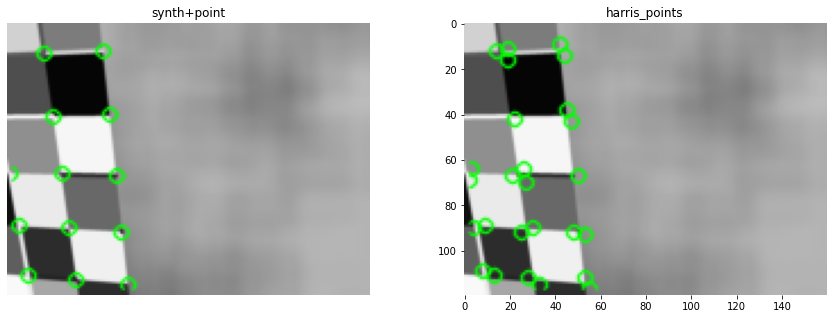

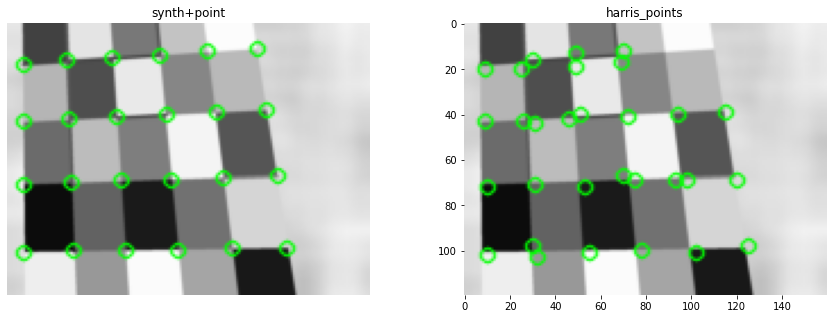

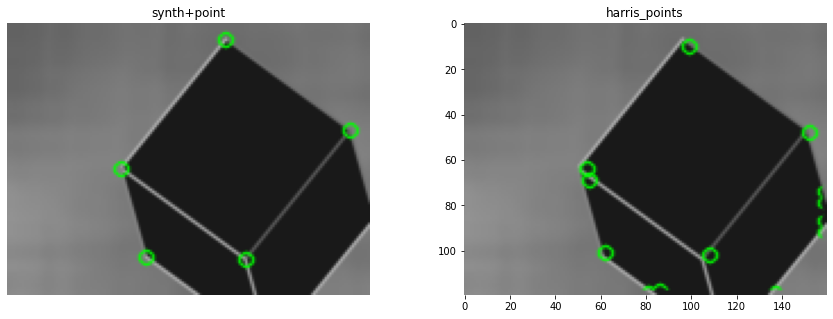

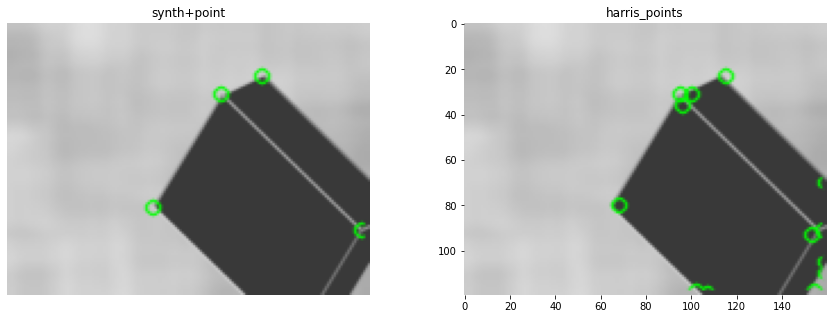

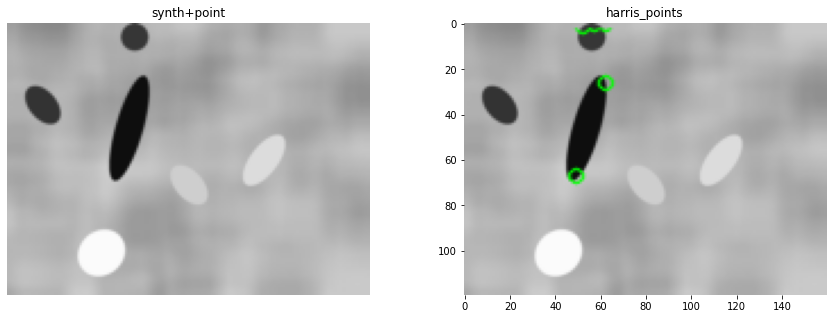

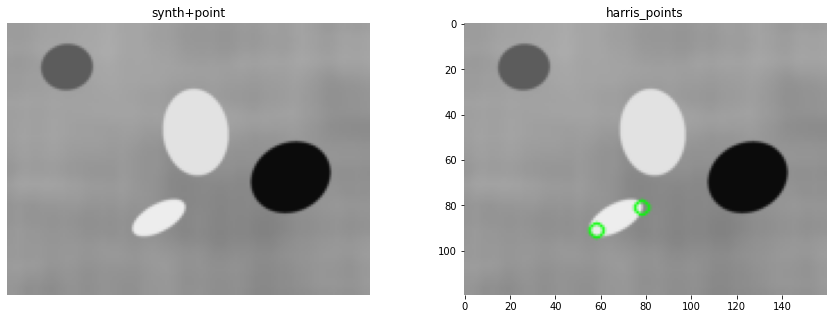

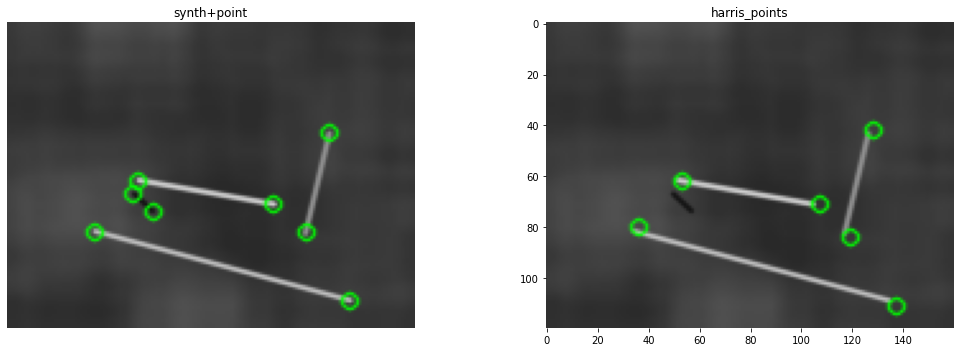

In [652]:
import tensorflow as tf


##Shapes generated by synthetic_shapes_generator
shape_dir_list = ['draw_checkerboard','draw_cube','draw_ellipses',
                  'draw_lines','draw_multiple_polygons','draw_star',
                  'draw_stripes']
num_images_per_shape = 2

## SYNTH IMAGE & POINT PATH
data_dir = "C:\\vrsk.psk.family\\Selva\\BitsPilani\\azure\\semester4\\semester4\\tmp\\"
img_dir = '\\images\\test\\'
p_dir = '\\points\\test\\'
synth_image_list, synth_point_list, synth_shapes_list = getRandomSynthList(shape_dir_list, data_dir, img_dir, p_dir,num_images_per_shape)

## MAGIC POINT IMAGE & POINT PATH
magic_point_data_dir = "C:\\vrsk.psk.family\\Selva\\BitsPilani\\azure\\semester4\\semester4\\experiment\\outputs\\magic-point_synth-export_all\\<synth_shape>\\points\\test\\"


################## DISPLAY SAMPLE IMAGES#############################
experiments = {
#     'magic_points' : {'classic' : False, 'func_name' : magicpoint, 'threshold' : 0.001, 'display_func_name' : display_magic, 'point_dir' : magic_point_data_dir },
    'harris_points' : {'classic' : True, 'func_name' : harris_detector, 'threshold' : 90000, 'display_func_name' : display_harris, 'point_dir' : None }, 
#     'sift_points' : {'classic' : True,'func_name' : sift_detector, 'threshold' : 0.001, 'display_func_name' : display_sift, 'point_dir' : None }
}

for key in experiments.keys():
    print('====================== '+key.upper()+' =======================')
    func_name = experiments[key]['func_name']
    threshold = experiments[key]['threshold']
    display_func = experiments[key]['display_func_name']
    point_dir = experiments[key]['point_dir']
    classic_model = experiments[key]['classic']
    if classic_model:
        data = iterateClassicData(synth_image_list, synth_point_list , synth_shapes_list, func_name)
    else:
        data = iterateData(synth_image_list, synth_point_list , synth_shapes_list, point_dir, func_name)
    ## Plot synthetic images generated.
    Tot = len(shape_dir_list) * num_images_per_shape
    Cols = 2

    # Compute Rows required
    Rows = Tot // Cols  # it should be 14
    Rows += Tot % Cols # ZERO added

    # Create a Position index
    Position = range(1,Tot,Cols)
    print(Position, Rows)

    for k in Position:
        try:
            data_rec = next(data)
            source_img = display(data_rec.copy())
            magic_img = display_func(data_rec.copy())

            fig , a =  plt.subplots(1,Cols, figsize = (15,5))
            for ax, incr in zip(a,range(0,Cols)):
                if incr == 0:
                    ax.imshow(source_img)
                    ax.get_yaxis().set_ticks([])
                    ax.get_xaxis().set_ticks([])
                    ax.set_title(str('synth+point'))
                if incr == 1:
                    ax.imshow(magic_img)
#                     ax.get_yaxis().set_ticks([])
#                     ax.get_xaxis().set_ticks([])
                    ax.set_title(str(key))

                for spine in ax.spines.values():  # remove frame
                    spine.set_visible(False)

        except tf.errors.OutOfRangeError:
            break

    plt.tight_layout()  

**PRECISION & RECALL Function**

In [10]:
def compute_precision_recall(synth_kp_map, synth_kp, model_kp, model_prob, dist_threshold):

    gt = np.where(synth_kp_map)
    gt = np.stack([gt[0], gt[1]], axis=-1)
    n_gt = len(gt)
    
    prob = model_prob
    pred = model_kp 
   
    # sort by probability
    sort_idx = np.argsort(prob)[::-1]
    prob = prob[sort_idx]
    pred = pred[sort_idx]
    
    diff = np.expand_dims(gt, axis=1) - np.expand_dims(pred, axis=0)
    dist = np.linalg.norm(diff, axis=-1)
    matches = np.less_equal(dist, dist_threshold)
    
    # Accumulate tp
    tp = []
    matched = np.zeros(len(gt))
    for m, m_idx in zip(matches, range(len(gt))):
        if np.any(m):
            gt_idx = np.argmax(m)
            if matched[m_idx] == 0 :
                matched[m_idx] = prob[gt_idx]
                tp.append(True)
#             matched[m_idx] = prob[gt_idx]
#             tp.append(True)
                
            else:
                tp.append(False)
        else:
            tp.append(False)
    
    tp = np.array(tp, bool)
    fp = np.logical_not(tp)

    return tp, fp, matched, n_gt

def experiment_level_pr( data, dist_threshold ):
    '''
        Loop through each image for calculating true positive/false positive
    '''
    tp, fp, prob, n_gt = [], [], [], 0
    while True:
        try:
            data_rec = next(data)
            synth_kp = data_rec['keypoints']
            synth_kp_map = data_rec['keypoints_map']
#             print(synth_kp.shape, synth_prob.shape)
            exp_kp = data_rec['model_keypoints']['points']
            exp_prob = data_rec['model_keypoints']['prob']
#             print('exp_kp.shape, exp_prob.shape: ',exp_kp.shape, exp_prob.shape)
            if exp_kp.size == 0:
                continue
            t, f, p, n = compute_precision_recall(synth_kp_map, synth_kp, exp_kp, exp_prob, dist_threshold)
#             print(t.shape, f.shape, p.shape, n)
            tp.append(t)
            fp.append(f)
            prob.append(p)
#             print(tp, fp, prob)
            n_gt += n

        except tf.errors.OutOfRangeError:
            break

    tp = np.concatenate(tp)
    fp = np.concatenate(fp)
    prob = np.concatenate(prob)

    # Sort in descending order of confidence
    sort_idx = np.argsort(prob)[::-1]
    tp = tp[sort_idx]
    fp = fp[sort_idx]
    prob = prob[sort_idx]

    tp_cum = np.cumsum(tp)
    fp_cum = np.cumsum(fp)
    recall = np.where(n_gt == 0, n_gt, tp_cum/n_gt)
    precision = np.where(tp_cum+fp_cum == 0, 0, tp_cum/(tp_cum+fp_cum))

    recall = np.concatenate([[0], recall, [1]])
    precision = np.concatenate([[0], precision, [0]])
    precision = np.maximum.accumulate(precision[::-1])[::-1]

    return precision, recall, prob

def compute_mAP(precision, recall):
    """
    Compute average precision.
    """
    return np.sum(precision[1:] * (recall[1:] - recall[:-1]))

# CALCULATE PRECISION & RECALL

====================== MAGIC_POINTS =======================
> magic_points
mAP: 0.9791347892613715
====================== HARRIS_POINTS =======================
> harris_points
mAP: 0.8064785207840957
====================== SIFT_POINTS =======================
pts.size  130
pts.size  84
pts.size  92
pts.size  68
pts.size  134
pts.size  104
pts.size  86
pts.size  60
pts.size  126
pts.size  42
pts.size  82
pts.size  62
pts.size  78
pts.size  56
pts.size  74
pts.size  66
pts.size  110
pts.size  68
pts.size  90
pts.size  72
pts.size  76
pts.size  42
pts.size  14
pts.size  98
pts.size  104
pts.size  64
pts.size  66
pts.size  56
pts.size  124
pts.size  36
pts.size  36
pts.size  60
pts.size  52
pts.size  44
pts.size  50
pts.size  50
pts.size  92
pts.size  38
pts.size  98
pts.size  126
pts.size  54
pts.size  80
pts.size  134
pts.size  52
pts.size  54
pts.size  88
pts.size  94
pts.size  112
pts.size  102
pts.size  66
pts.size  46
pts.size  66
pts.size  146
pts.size  36
pts.size  120
pts.size  10


pts.size  24
pts.size  6
pts.size  6
pts.size  14
pts.size  0
No keypoints found.
pts.size  16
pts.size  34
pts.size  0
No keypoints found.
pts.size  2
pts.size  18
pts.size  12
pts.size  36
pts.size  2
pts.size  28
pts.size  4
pts.size  14
pts.size  22
pts.size  0
No keypoints found.
pts.size  0
No keypoints found.
pts.size  46
pts.size  14
pts.size  0
No keypoints found.
pts.size  8
pts.size  6
pts.size  30
pts.size  16
pts.size  10
pts.size  0
No keypoints found.
pts.size  0
No keypoints found.
pts.size  4
pts.size  0
No keypoints found.
pts.size  34
pts.size  38
pts.size  10
pts.size  0
No keypoints found.
pts.size  4
pts.size  8
pts.size  0
No keypoints found.
pts.size  4
pts.size  12
pts.size  12
pts.size  14
pts.size  34
pts.size  0
No keypoints found.
pts.size  28
pts.size  6
pts.size  26
pts.size  0
No keypoints found.
pts.size  0
No keypoints found.
pts.size  8
pts.size  2
pts.size  38
pts.size  0
No keypoints found.
pts.size  0
No keypoints found.
pts.size  20
pts.size  0
No

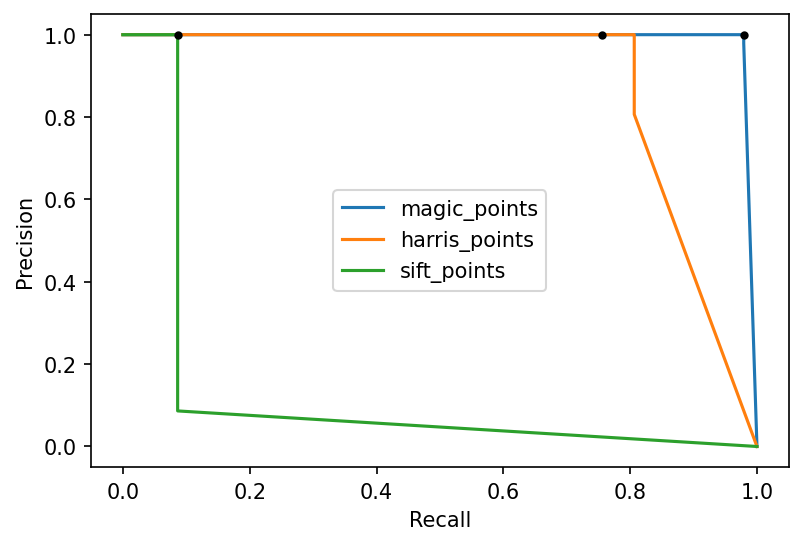

In [688]:
import tensorflow as tf


##Shapes generated by synthetic_shapes_generator
shape_dir_list = ['draw_checkerboard','draw_cube','draw_ellipses',
                  'draw_lines','draw_multiple_polygons','draw_star',
                  'draw_stripes']
num_images_per_shape = 100

## SYNTH IMAGE & POINT PATH
data_dir = "C:\\vrsk.psk.family\\Selva\\BitsPilani\\azure\\semester4\\semester4\\tmp\\"
img_dir = '\\images\\test\\'
p_dir = '\\points\\test\\'
synth_image_list, synth_point_list, synth_shapes_list = getRandomSynthList(shape_dir_list, data_dir, img_dir, p_dir,num_images_per_shape)

## MAGIC POINT IMAGE & POINT PATH
magic_point_data_dir = "C:\\vrsk.psk.family\\Selva\\BitsPilani\\azure\\semester4\\semester4\\experiment\\outputs\\magic-point_synth-export_all\\<synth_shape>\\points\\test\\"


################## DISPLAY SAMPLE IMAGES#############################
experiments = {
    'magic_points' : {'threshold': 0.001, 'classic' : False, 'func_name' : magicpoint, 'threshold' : 0.001, 'display_func_name' : display_magic, 'point_dir' : magic_point_data_dir },
    'harris_points' : {'threshold': 90000,'classic' : True, 'func_name' : harris_detector, 'threshold' : 90000, 'display_func_name' : display_harris, 'point_dir' : None }, 
#     'sift_points' : {'classic' : True,'func_name' : sift_detector, 'threshold' : 0.001, 'display_func_name' : display_sift, 'point_dir' : None }
}

plt.figure(dpi=150)

for key in experiments.keys():
    print('====================== '+key.upper()+' =======================')
    func_name = experiments[key]['func_name']
    threshold = experiments[key]['threshold']
    display_func = experiments[key]['display_func_name']
    point_dir = experiments[key]['point_dir']
    classic_model = experiments[key]['classic']
    threshold = experiments[key]['threshold']
     
    if classic_model:
        data = iterateClassicData(synth_image_list, synth_point_list , synth_shapes_list, func_name)
    else:
        data = iterateData(synth_image_list, synth_point_list , synth_shapes_list, point_dir, func_name)
    
    p, r, prob = experiment_level_pr(data, dist_threshold=4)
    plt.plot(r, p, label=key);

    mAP = compute_mAP(p, r)
    print('> {}'.format(key))
    print('mAP: {}'.format(mAP))

    op_idx = np.max(np.where(prob > threshold))
    plt.plot(r[op_idx], p[op_idx], marker='o', color='k', markersize=3)

plt.legend(), plt.xlabel('Recall'), plt.ylabel('Precision');

# REPEATABILITY 

In [11]:
def keypoint_map_prob(image, keypoints, prob):
    
    image_shape = image.shape[:2]
    keypoint_map = np.zeros(image_shape)
#     print('shape, keypioints: ', keypoints.shape, keypoints)
    idx = np.array(keypoints).T
    row,col = tuple(idx[0]),tuple(idx[1])
    keypoint_map[row,col] = prob
    
    print('=================keypionts size: ', idx.size)

    return keypoint_map.astype(np.int32)

def tf_keypoint_map_prob(image, keypoints, prob):
    result = tf.py_func(keypoint_map_prob,[image, keypoints, prob], tf.int32)
    return result

def generate_model_specific(data, func_name):
    image = data['image']
    warped_image = data['warped_image']

    result = func_name(image)
    warped_result = func_name(warped_image)
    
    data['prob'] = result['prob'] #tf_keypoint_map_prob(image, result['points'], result['prob'])
    data['points'] = result['points']
    data['warped_prob'] = warped_result['prob'] # tf_keypoint_map_prob(warped_image, warped_result['points'], warped_result['prob'])
    data['warped_points'] = warped_result['points']
#     print('data.keys ', data.keys())
    
    return data

def get_files_listing(data_dir, image_dir, num_images_per_shape):
    ifiles_list = [f for f in os.listdir(data_dir)]
    random_ifiles = np.random.choice(ifiles_list, num_images_per_shape)
    random_img_files = [f.replace('.npz', '.jpg') for f in random_ifiles]
    
    random_ifiles = [os.path.join(data_dir, f) for f in random_ifiles]
    random_img_files = [os.path.join(image_dir, f) for f in random_img_files]
    return random_ifiles, random_img_files
    
    
def iterateRepeatableData(random_ifiles, random_img_files, func_name, is_superpoint ):


        
    data = tf.data.Dataset.from_tensor_slices((random_ifiles,random_img_files))

    data = data.map(
            lambda data_file, img_file:
                (
                    tf.py_func(_path, [data_file], tf.string),
                    tf.py_func(_path, [img_file], tf.string)
                )
    )    
    
    data = data.map(
            lambda data_file, img_file:
                (
                   super_points(data_file)
                  
                )   
    )
    
    if is_superpoint:
        data = data.map( lambda superpoint:  { 'superpoint' : superpoint } )
    else:
        data = data.map( lambda superpoint:  { 'superpoint' : generate_model_specific(superpoint, func_name) } )
   
    tf_next = data.make_one_shot_iterator().get_next()
    sess = tf.Session()
    while True:
        yield sess.run(tf_next)


In [12]:
import numpy as np
from os import path as osp
from glob import glob

from superpoint.settings import EXPER_PATH


def compute_repeatability(datarec, keep_k_points=300,
                          distance_thresh=3, verbose=False):
    """
    Compute the repeatability. The experiment must contain in its output the prediction
    on 2 images, an original image and a warped version of it, plus the homography
    linking the 2 images.
    """
    def warp_keypoints(keypoints, H):
        num_points = keypoints.shape[0]
        homogeneous_points = np.concatenate([keypoints, np.ones((num_points, 1))],
                                            axis=1)
        warped_points = np.dot(homogeneous_points, np.transpose(H))
        return warped_points[:, :2] / warped_points[:, 2:]

    def filter_keypoints(points, shape):
        """ Keep only the points whose coordinates are
        inside the dimensions of shape. """
        mask = (points[:, 0] >= 0) & (points[:, 0] < shape[0]) &\
               (points[:, 1] >= 0) & (points[:, 1] < shape[1])
        return points[mask, :]

    def keep_true_keypoints(points, H, shape):
        """ Keep only the points whose warped coordinates by H
        are still inside shape. """
        warped_points = warp_keypoints(points[:, [1, 0]], H)
        warped_points[:, [0, 1]] = warped_points[:, [1, 0]]
        mask = (warped_points[:, 0] >= 0) & (warped_points[:, 0] < shape[0]) &\
               (warped_points[:, 1] >= 0) & (warped_points[:, 1] < shape[1])
        return points[mask, :]

    def select_k_best(points, k):
        """ Select the k most probable points (and strip their proba).
        points has shape (num_points, 3) where the last coordinate is the proba. """
        sorted_prob = points[points[:, 2].argsort(), :2]
        start = min(k, points.shape[0])
        return sorted_prob[-start:, :]

  
    repeatability = []
    N1s = []
    N2s = []

    while True:
        try:
            model_data = next(datarec)
            data = model_data['superpoint']
            
#             print('prob, point, warp_prob, warp_point', data['prob'].shape,data['points'].shape,data['warped_prob'].shape,data['warped_points'].shape)
            
            shape = data['warped_prob'].shape
            H = data['homography']

            # Filter out predictions
            keypoints = np.where(data['prob'] > 0)
            if keypoints[0].size == 0:
#                 print('======keypoints size is zero')
                continue
            prob = data['prob'][keypoints[0], keypoints[1]]
            keypoints = np.stack([keypoints[0], keypoints[1]], axis=-1)
            warped_keypoints = np.where(data['warped_prob'] > 0)
            warped_prob = data['warped_prob'][warped_keypoints[0], warped_keypoints[1]]
            warped_keypoints = np.stack([warped_keypoints[0],
                                         warped_keypoints[1],
                                         warped_prob], axis=-1)
            warped_keypoints = keep_true_keypoints(warped_keypoints, np.linalg.inv(H),
                                                   data['prob'].shape)

            # Warp the original keypoints with the true homography
            true_warped_keypoints = warp_keypoints(keypoints[:, [1, 0]], H)
            true_warped_keypoints = np.stack([true_warped_keypoints[:, 1],
                                              true_warped_keypoints[:, 0],
                                              prob], axis=-1)
            true_warped_keypoints = filter_keypoints(true_warped_keypoints, shape)

            # Keep only the keep_k_points best predictions
            warped_keypoints = select_k_best(warped_keypoints, keep_k_points)
            true_warped_keypoints = select_k_best(true_warped_keypoints, keep_k_points)

            # Compute the repeatability
            N1 = true_warped_keypoints.shape[0]
            N2 = warped_keypoints.shape[0]
            N1s.append(N1)
            N2s.append(N2)
            true_warped_keypoints = np.expand_dims(true_warped_keypoints, 1)
            warped_keypoints = np.expand_dims(warped_keypoints, 0)
            # shapes are broadcasted to N1 x N2 x 2:
            norm = np.linalg.norm(true_warped_keypoints - warped_keypoints,
                                  ord=None, axis=2)
#             print('norm: ',norm)
            count1 = 0
            count2 = 0
            if N2 != 0:
                min1 = np.min(norm, axis=1)
                count1 = np.sum(min1 <= distance_thresh)
            if N1 != 0:
                min2 = np.min(norm, axis=0)
                count2 = np.sum(min2 <= distance_thresh)
            if N1 + N2 > 0:
                repeatability.append((count1 + count2) / (N1 + N2))
            
#             print('count1, count2', count1, count2)
        except tf.errors.OutOfRangeError:
                break
    if verbose:
        print("Average number of points in the first image: " + str(np.mean(N1s)))
        print("Average number of points in the second image: " + str(np.mean(N2s)))
    return np.mean(repeatability)

====================== SUPER_POINT =======================
range(1, 2, 2) 1
            lambda data_file, img_file:

If this is a lambda function, the error may be avoided by creating the lambda in a standalone statement.
            lambda data_file, img_file:

If this is a lambda function, the error may be avoided by creating the lambda in a standalone statement.
====================== HARRIS_POINT =======================
range(1, 2, 2) 1
            lambda data_file, img_file:

If this is a lambda function, the error may be avoided by creating the lambda in a standalone statement.
            lambda data_file, img_file:

If this is a lambda function, the error may be avoided by creating the lambda in a standalone statement.
data.keys  dict_keys(['prob', 'warped_prob', 'desc', 'warped_desc', 'homography', 'name', 'image', 'warped_image', 'points', 'warped_points'])
====================== SIFT_POINT =======================
range(1, 2, 2) 1
            lambda data_file, img_file:

If t

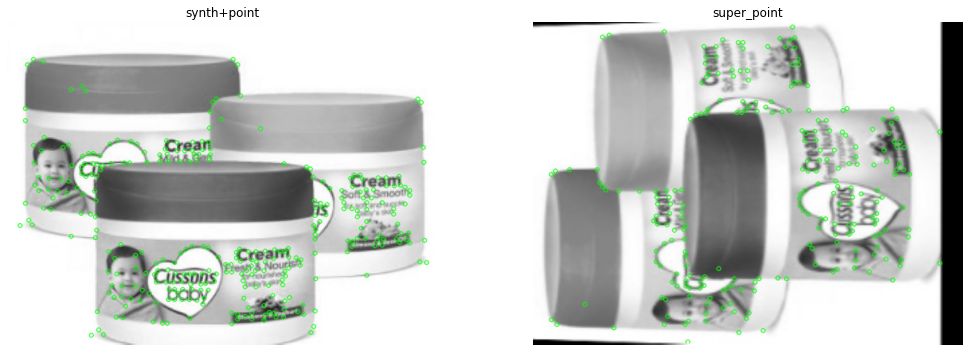

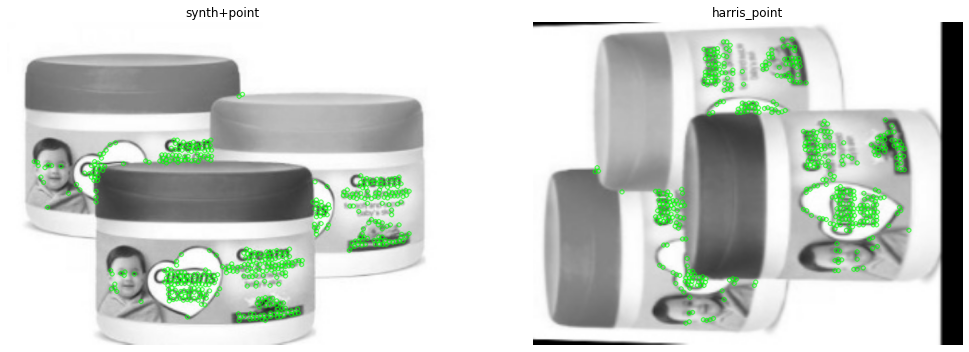

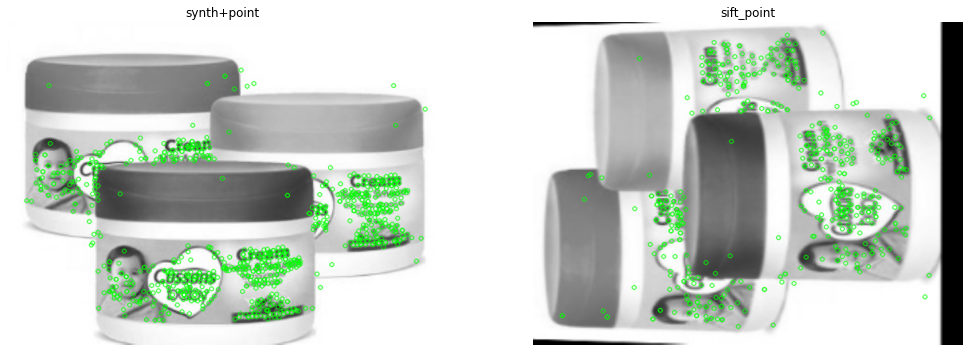

In [13]:
import tensorflow as tf


num_images_per_shape = 1

## MAGIC POINT IMAGE & POINT PATH
# data_dir = "C:\\vrsk.psk.family\\Selva\\BitsPilani\\azure\\semester4\\semester4\\experiment\\outputs\\superpoint_pmpatches-3"
data_dir = "C:\\vrsk.psk.family\\Selva\\BitsPilani\\azure\\semester4\\semester4\\experiment\\outputs\\superpoint_pm_match-1"
image_dir = 'C:\\vrsk.psk.family\\Selva\\BitsPilani\\shopee-product-matching\\train_images'

################## DISPLAY SAMPLE IMAGES#############################
experiments = {
    'super_point' : {'threshold': 0.001, 'is_superpoint' : True, 'func_name' : super_points, 'threshold' : 0.001, 'display_func_name' : display_model2, 'point_dir' : None },
    'harris_point' : {'threshold': 90000,'is_superpoint' : False, 'func_name' : harris_detector2, 'threshold' : 90000, 'display_func_name' : display_model2, 'point_dir' : None }, 
    'sift_point' : {'threshold': 0.0001,'is_superpoint' : False,'func_name' : sift_detector2, 'threshold' : 0.001, 'display_func_name' : display_model2, 'point_dir' : None }
}

patch_file_list, image_file_list = get_files_listing(data_dir, image_dir, num_images_per_shape)

for key in experiments.keys():
    print('====================== '+key.upper()+' =======================')
    func_name = experiments[key]['func_name']
    threshold = experiments[key]['threshold']
    display_func = experiments[key]['display_func_name']
    point_dir = experiments[key]['point_dir']
    is_superpoint = experiments[key]['is_superpoint']
    threshold = experiments[key]['threshold']
     
    
    data = iterateRepeatableData(patch_file_list, image_file_list, func_name, is_superpoint)
    
      ## Plot synthetic images generated.
    Tot = num_images_per_shape * 2
    Cols = 2

    # Compute Rows required
    Rows = Tot // Cols  # it should be 14
    Rows += Tot % Cols # ZERO added

    # Create a Position index
    Position = range(1,Tot,Cols)
    print(Position, Rows)

    for k in Position:
        try:
            data_rec = next(data)
            data_rec_cp = data_rec['superpoint'].copy()
#             print('img dataype: ', data_rec_cp['image'].dtype)
            source_img = display_func(data_rec_cp['image'], data_rec_cp['points'])
            magic_img = display_func(data_rec_cp['warped_image'], data_rec_cp['warped_points'])
            
#             source_img = data_rec_cp['image']
#             magic_img = data_rec_cp['warped_image']

            fig , a =  plt.subplots(1,Cols, figsize = (15,5))
            for ax, incr in zip(a,range(0,Cols)):
                if incr == 0:
                    ax.imshow(source_img,cmap='gray')
                    ax.get_yaxis().set_ticks([])
                    ax.get_xaxis().set_ticks([])
                    ax.set_title(str('synth+point'))
                if incr == 1:
                    ax.imshow(magic_img,cmap='gray')
                    ax.get_yaxis().set_ticks([])
                    ax.get_xaxis().set_ticks([])
                    ax.set_title(str(key))

                for spine in ax.spines.values():  # remove frame
                    spine.set_visible(False)

        except tf.errors.OutOfRangeError:
            break

    plt.tight_layout()  
    
       
#     repeatability = compute_repeatability(data, keep_k_points=300, distance_thresh=3)
#     print('> {}: {}'.format(key, repeatability))

In [14]:
import tensorflow as tf


num_images_per_shape = 25

## MAGIC POINT IMAGE & POINT PATH
# data_dir = "C:\\vrsk.psk.family\\Selva\\BitsPilani\\azure\\semester4\\semester4\\experiment\\outputs\\superpoint_pmpatches-3"
data_dir = "C:\\vrsk.psk.family\\Selva\\BitsPilani\\azure\\semester4\\semester4\\experiment\\outputs\\superpoint_pm_match-1"

image_dir = 'C:\\vrsk.psk.family\\Selva\\BitsPilani\\shopee-product-matching\\train_images'

################## DISPLAY SAMPLE IMAGES#############################
experiments = {
    'super_point' : {'threshold': 0.001, 'is_superpoint' : True, 'func_name' : super_points, 'threshold' : 0.001, 'display_func_name' : display_model2, 'point_dir' : None },
    'harris_point' : {'threshold': 90000,'is_superpoint' : False, 'func_name' : harris_detector2, 'threshold' : 90000, 'display_func_name' : display_model2, 'point_dir' : None }, 
    'sift_point' : {'threshold': 0.0001,'is_superpoint' : False,'func_name' : sift_detector2, 'threshold' : 0.001, 'display_func_name' : display_model2, 'point_dir' : None }
}

patch_file_list, image_file_list = get_files_listing(data_dir, image_dir, num_images_per_shape)


for key in experiments.keys():
    print('====================== '+key.upper()+' =======================')
    func_name = experiments[key]['func_name']
    threshold = experiments[key]['threshold']
    display_func = experiments[key]['display_func_name']
    point_dir = experiments[key]['point_dir']
    is_superpoint = experiments[key]['is_superpoint']
    threshold = experiments[key]['threshold']
     
    
    data = iterateRepeatableData(patch_file_list, image_file_list, func_name, is_superpoint)
    
   
    repeatability = compute_repeatability(data, keep_k_points=300, distance_thresh=3)
    print('> {}: {}'.format(key, repeatability))

====================== SUPER_POINT =======================
            lambda data_file, img_file:

If this is a lambda function, the error may be avoided by creating the lambda in a standalone statement.
            lambda data_file, img_file:

If this is a lambda function, the error may be avoided by creating the lambda in a standalone statement.
> super_point: 0.6180622723993145
====================== HARRIS_POINT =======================
            lambda data_file, img_file:

If this is a lambda function, the error may be avoided by creating the lambda in a standalone statement.
            lambda data_file, img_file:

If this is a lambda function, the error may be avoided by creating the lambda in a standalone statement.
data.keys  dict_keys(['prob', 'warped_prob', 'desc', 'warped_desc', 'homography', 'name', 'image', 'warped_image', 'points', 'warped_points'])
> harris_point: 0.42340000000000005
====================== SIFT_POINT =======================
            lambda data_fi

# Localization Error

In [13]:
import tensorflow as tf

def _kp_map_reader(image, name, kp_map_dir):
    name = name.decode('utf-8')+'.npz'
#     print('name, kp_map_dir ', name, kp_map_dir)
    mp = np.load(kp_map_dir+'//'+name, allow_pickle=True)
#     print('mp.files: ', mp.files)    
    keypoints = mp['points']
    image_shape = image.shape[:2]
    keypoints_rounded = np.round(keypoints).astype(np.int32)
    keypoint_map = np.zeros(image_shape)
    if keypoints_rounded.size == 0:
        return keypoint_map.astype(np.int32)
    kp = np.minimum(keypoints_rounded,(image_shape[0]-1,image_shape[1]-1)) #max sealing above rounded values to image shape
    
    idx = np.array(kp).T
    row,col = tuple(idx[0]),tuple(idx[1])
    keypoint_map[row,col] = 1
    return keypoint_map.astype(np.int32)

def compute_loc_error(datarec, kp_map_dir, prob_thresh=0.5, distance_thresh=2):
    """
    Compute the localization error.
    """
    error = []
    while True:
        try:
            model_data = next(datarec)
            data = model_data['superpoint']
            # Read data
            _image = data['image']
            _name = data['name']
#             print('_image, _name: ',_image, _name)
            kp_map = _kp_map_reader(_image, _name, kp_map_dir)
#             print('kp_map.shape', kp_map.shape)
            gt = np.where(kp_map)
            gt = np.stack([gt[0], gt[1]], axis=-1)
            prob = data['prob']

            # Filter out predictions
            mask = np.where( (prob > prob_thresh[0]) & (prob <= prob_thresh[1]))
            pred = np.array(mask).T
            prob = prob[mask]

            if not len(gt) or not len(pred):
                return []

            diff = np.expand_dims(pred, axis=1) - np.expand_dims(gt, axis=0)
            dist = np.linalg.norm(diff, axis=-1)
            dist = np.min(dist, axis=1)
            correct_dist = dist[np.less_equal(dist, distance_thresh)]
            
            error.append(correct_dist)
            
        except tf.errors.OutOfRangeError:
                break

    return np.mean(np.concatenate(error))


num_images_per_shape = 5

## MAGIC POINT IMAGE & POINT PATH
# data_dir = "C:\\vrsk.psk.family\\Selva\\BitsPilani\\azure\\semester4\\semester4\\experiment\\outputs\\superpoint_pmpatches-3"
data_dir = "C:\\vrsk.psk.family\\Selva\\BitsPilani\\azure\\semester4\\semester4\\experiment\\outputs\\superpoint_pm_match-1"
image_dir = 'C:\\vrsk.psk.family\\Selva\\BitsPilani\\shopee-product-matching\\train_images'
kp_map_dir = "C:\\vrsk.psk.family\\Selva\\BitsPilani\\azure\\semester4\\semester4\\experiment\\outputs\\magic-point_pm-export1"

################## DISPLAY SAMPLE IMAGES#############################
experiments = {
    'super_point' : {'threshold': 0.001, 'is_superpoint' : True, 'func_name' : super_points, 'threshold' : [0.5,1], 'display_func_name' : display_model2, 'point_dir' : None },
    'harris_point' : {'threshold': 90000,'is_superpoint' : False, 'func_name' : harris_detector2, 'threshold' : [0.0001,90000], 'display_func_name' : display_model2, 'point_dir' : None }, 
    'sift_point' : {'threshold': 0.0001,'is_superpoint' : False,'func_name' : sift_detector2, 'threshold' : [0.001,1], 'display_func_name' : display_model2, 'point_dir' : None }
}

patch_file_list, image_file_list = get_files_listing(data_dir, image_dir, num_images_per_shape)


for key in experiments.keys():
    print('====================== '+key.upper()+' =======================')
    func_name = experiments[key]['func_name']
    threshold = experiments[key]['threshold']
    display_func = experiments[key]['display_func_name']
    point_dir = experiments[key]['point_dir']
    is_superpoint = experiments[key]['is_superpoint']
    threshold = experiments[key]['threshold']
     
    
    data = iterateRepeatableData(patch_file_list, image_file_list, func_name, is_superpoint)
    
   
    loc_error = compute_loc_error(data,  kp_map_dir, prob_thresh=threshold, distance_thresh=2)
    print('> {}: {}'.format(key, loc_error))

====================== SUPER_POINT =======================
            lambda data_file, img_file:

If this is a lambda function, the error may be avoided by creating the lambda in a standalone statement.
            lambda data_file, img_file:

If this is a lambda function, the error may be avoided by creating the lambda in a standalone statement.
> super_point: 1.0
====================== HARRIS_POINT =======================
            lambda data_file, img_file:

If this is a lambda function, the error may be avoided by creating the lambda in a standalone statement.
            lambda data_file, img_file:

If this is a lambda function, the error may be avoided by creating the lambda in a standalone statement.
data.keys  dict_keys(['prob', 'warped_prob', 'desc', 'warped_desc', 'homography', 'name', 'image', 'warped_image', 'points', 'warped_points'])
> harris_point: 1.3290655782027168
====================== SIFT_POINT =======================
            lambda data_file, img_file:

I